In [1]:
from model import create_model

nn4_small2_pretrained = create_model()

Using TensorFlow backend.


In [2]:
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext=='.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')
print('metadata created')
print(metadata)

metadata created
[images/IIT2016044/sindhu_007.jpeg images/IIT2016044/sindhu_004.jpeg
 images/IIT2016044/sindhu_009.jpeg images/IIT2016044/sindhu_010.jpg
 images/IIT2016044/sindhu_006.jpeg images/IIT2016044/sindhu_002.jpg
 images/IIT2016044/sindhu_008.jpeg images/IIT2016044/sindhu_003.jpg
 images/IIT2016044/sindhu_005.jpeg
 images/Colin_Powell/Colin_Powell_0004.jpg
 images/Colin_Powell/Colin_Powell_0006.jpg
 images/Colin_Powell/Colin_Powell_0005.jpg
 images/Colin_Powell/Colin_Powell_0008.jpg
 images/Colin_Powell/Colin_Powell_0001.jpg
 images/Colin_Powell/Colin_Powell_0003.jpg
 images/Colin_Powell/Colin_Powell_0007.jpg
 images/Colin_Powell/Colin_Powell_0002.jpg
 images/Colin_Powell/Colin_Powell_0010.jpg
 images/Colin_Powell/Colin_Powell_0009.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0006.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg
 

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1) #BGR
    return img[...,::-1] #RGB


alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

#combined transformation
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [5]:
embedded = np.zeros((metadata.shape[0], 128)) 

real_name = {}

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        real_name[os.path.dirname(m.image_path()[7:])] = embedded[i]
        print(i)
        print(m.name)

def real_names():
    return real_name



0
IIT2016044
1
IIT2016044
2
IIT2016044
3
IIT2016044
4
IIT2016044
5
IIT2016044
7
IIT2016044
8
IIT2016044
9
Colin_Powell
10
Colin_Powell
11
Colin_Powell
12
Colin_Powell
13
Colin_Powell
14
Colin_Powell
15
Colin_Powell
16
Colin_Powell
17
Colin_Powell
18
Colin_Powell
19
Arnold_Schwarzenegger
20
Arnold_Schwarzenegger
21
Arnold_Schwarzenegger
22
Arnold_Schwarzenegger
23
Arnold_Schwarzenegger
24
Arnold_Schwarzenegger
25
Arnold_Schwarzenegger
26
Arnold_Schwarzenegger
27
Arnold_Schwarzenegger
28
Arnold_Schwarzenegger
29
Donald_Rumsfeld
30
Donald_Rumsfeld
31
Donald_Rumsfeld
32
Donald_Rumsfeld
33
Donald_Rumsfeld
34
Donald_Rumsfeld
35
Donald_Rumsfeld
36
Donald_Rumsfeld
37
Donald_Rumsfeld
38
Donald_Rumsfeld
39
Gerhard_Schroeder
40
Gerhard_Schroeder
41
Gerhard_Schroeder
42
Gerhard_Schroeder
43
Gerhard_Schroeder
44
Gerhard_Schroeder
45
Gerhard_Schroeder
46
Gerhard_Schroeder
47
Gerhard_Schroeder
48
Gerhard_Schroeder
49
BIM2016002
50
BIM2016002
51
BIM2016002
52
BIM2016002
53
BIM2016002
54
BIM2016002
55


In [6]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

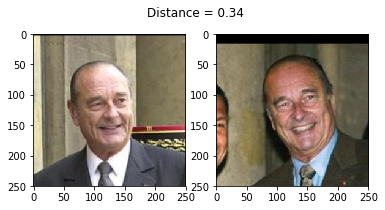

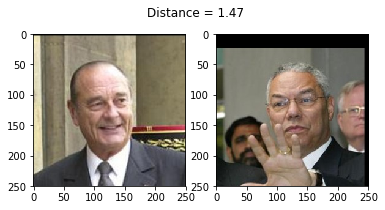

In [7]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(6,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(78, 76)
show_pair(78, 17)

In [8]:
def recognize(embedded):
    min_dist = 100
    _id = None
    for name,emb in real_name.items():
        dist = np.sum(np.square(emb - embedded))


        if dist < min_dist:
            min_dist = dist
            _id = name
    if min_dist > 0.58:
        print(min_dist)
        return None
    else:
        print(min_dist)
        return _id

    

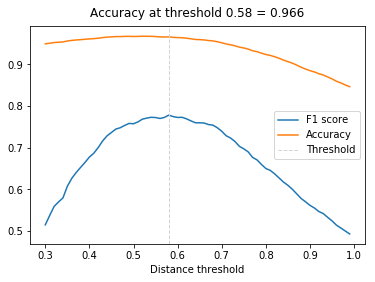

In [9]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [10]:
embedded = np.zeros((1, 128))


def recognize_image(image_path):
    img = load_image(image_path)
    img = align_image(img)
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded = nn4_small2_pretrained.predict(np.expand_dims(np.array(img), axis=0))[0]
        name = recognize(embedded)
        print(name)
        return name
    return None


cap = cv2.VideoCapture(0)


# def webcam_recognize():
#     while(True): 
#         ret, frame = cap.read()
#         cv2.imwrite('temp.jpg',frame)
#         cv2.waitKey(20)
#         if 'temp.jpg' is not None:
#             name = recognize_image('temp.jpg')
#             cv2.imshow('temp',frame)
#             print(name)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
        
#     cap.release()
#     cv2.destroyAllWindows()


   # webcam_recognize()
# recognize_image('.jpg')

#students list for gspread updations
students = []

from mtcnn.mtcnn import MTCNN
import pickle
def multiple_recognize():
    while(True):
        ret,frame = cap.read()
        cv2.imwrite('temp.jpg',frame)
        detector = MTCNN()
        image = load_image('temp.jpg')
        faces = detector.detect_faces(image)
        print(faces)
        if faces is not None:
            for face in faces:
                (x,y,w,h) = face['box']
                cv2.imwrite('temp.jpg',frame)
                if 'temp.jpg' is not None:
                    name = recognize_image('temp.jpg')
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),5)
                    cv2.imshow('Faces',frame)
                    if name!=None and name not in students:    
                        students.append(name)
        stud_names = open('present.pickle','wb')
        pickle.dump(students, stud_names,protocol=2)
        stud_names.close()
                    
                      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
                
#                 cv2.imshow('parts',image[y:y+h,x:x+w])

multiple_recognize()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[{'box': [329, 301, 107, 139], 'confidence': 0.9945863485336304, 'keypoints': {'left_eye': (371, 353), 'right_eye': (419, 349), 'nose': (404, 385), 'mouth_left': (377, 412), 'mouth_right': (416, 408)}}]
[{'box': [330, 301, 108, 140], 'confidence': 0.9953557252883911, 'keypoints': {'left_eye': (371, 353), 'right_eye': (420, 349), 'nose': (404, 384), 'mouth_left': (377, 413), 'mouth_right': (416, 408)}}]
[{'box': [329, 300, 104, 130], 'confidence': 0.9954391121864319, 'keypoints': {'left_eye': (372, 350), 'right_eye': (416, 347), 'nose': (402, 377), 'mouth_left': (377, 403), 'mouth_right': (412, 399)}}]
[{'box': [330, 301, 104, 128], 'confidence': 0.993794322013855, 'keypoints': {'left_eye': (371, 350), 'right_eye': (417, 347), 'nose': (402, 377), 'mouth_left': (377, 403), 'mouth_right': (412, 399)}}]
[{'box': [329, 301, 103, 127], 'confidence'

In [11]:
import datetime
import os
import subprocess as s

s.call("python mark_attendance.py", shell=True)
# today = datetime.date.today()
# formatted_date = today.strftime("%m-%d-%Y")
# print(formatted_date)

# from mark_attendance import mark_attendance

# mark_attendance(students)


1